In [2]:
# Import SlackerGPU to set env variables, import tf (tf 1.4)
from handcam.ltt.util import SlackerGPU
slackerGPU = SlackerGPU.SlackerGPU(username='ltaverne',
                                   desired_server='ait-server-03',
                                   num_gpus=0)
import tensorflow as tf

try:
    del flags
except NameError:
    pass
try:
    del FLAGS
except NameError:
    pass

flags = tf.app.flags

#State your dataset directory
flags.DEFINE_string('dataset_dir', '/local/home/luke/datasets/rgbd-dataset/', 'String: Your dataset directory')

# The number of images in the validation set. You would have to know the total number of examples in advance. This is essentially your evaluation dataset.
flags.DEFINE_float('validation_size', 0.1, 'Float: The proportion of examples in the dataset to be used for validation')

# The number of shards per dataset split.
flags.DEFINE_integer('num_shards', 1000, 'Int: Number of shards to split the TFRecord files')

# Seed for repeatability.
flags.DEFINE_integer('random_seed', 0, 'Int: Random seed to use for repeatability.')

#Output filename for the naming the TFRecord file
flags.DEFINE_string('tfrecord_filename', 'uw-rgbd', 'String: The output filename to name your TFRecord file')

FLAGS = flags.FLAGS

SlackerGPU: Using gpus [] on server: ait-server-03


/local/home/luke/.virtualenvs/mkl_dnn/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# other imports
import random
from random import shuffle
random.seed(FLAGS.random_seed)
import glob
import os
import math
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(FLAGS.random_seed)
from scipy.ndimage import rotate
from handcam.ltt.util.Utils import apply_alpha_matting_tf

from handcam.ltt.datasets.handcam import HandCamDataHandler
data_handler_handcam = HandCamDataHandler.Handler()
from handcam.ltt.datasets.handcam.HandCamDataHandler import HandGenerator
hand_generator = HandGenerator(f=data_handler_handcam.f,
                               batch_size=1)

In [4]:
# Get an iterator for all of the images
shuffle_data = True
dataset_root = FLAGS.dataset_dir
depth_image_pattern = dataset_root + "*/*/*_depth.png"
class_names = sorted([i for i in next(os.walk(dataset_root))[1]])
class_names_to_index = dict(zip(class_names,range(len(class_names))))
#'/local/home/luke/datasets/rgbd-dataset/hand_towel/hand_towel_2/hand_towel_2_4_184_depth.png'
# depth_iterator = glob.iglob(depth_image_pattern)
depth_filenames = glob.glob(depth_image_pattern)
print(class_names_to_index)
print(len(depth_filenames))

{'stapler': 46, 'hand_towel': 23, 'water_bottle': 50, 'glue_stick': 21, 'pitcher': 37, 'toothbrush': 48, 'bowl': 5, 'coffee_mug': 11, 'food_box': 16, 'plate': 38, 'pear': 36, 'cell_phone': 9, 'mushroom': 31, 'potato': 40, 'ball': 1, 'rubber_eraser': 41, 'bell_pepper': 3, 'lime': 29, 'cap': 8, 'comb': 12, 'notebook': 32, 'orange': 34, 'dry_battery': 13, 'keyboard': 25, 'scissors': 42, 'kleenex': 26, 'calculator': 6, 'cereal_box': 10, 'garlic': 20, 'food_cup': 18, 'pliers': 39, 'lemon': 27, 'flashlight': 14, 'soda_can': 44, 'sponge': 45, 'food_can': 17, 'food_bag': 15, 'binder': 4, 'shampoo': 43, 'camera': 7, 'banana': 2, 'marker': 30, 'toothpaste': 49, 'lightbulb': 28, 'greens': 22, 'food_jar': 19, 'onion': 33, 'peach': 35, 'tomato': 47, 'instant_noodles': 24, 'apple': 0}
208410


In [5]:
def get_class_name_from_path(depth_im_path):
    return depth_im_path.split(dataset_root)[1].split('/')[0]

def get_rgb_path(depth_im_path):
    return depth_im_path.split("_depth.png")[0] + ".png"

def shuffle_dataset(rgb_filenames, depth_filenames, labels):
    c = list(zip(rgb_filenames, depth_filenames, labels))
    shuffle(c)
    
    return zip(*c) # rgb_filenames, depth_filenames, labels

# Get label for every filename
ids = [class_names_to_index[get_class_name_from_path(i)] for i in depth_filenames]
# Get corresponding rgb filename for each depth filename
rgb_filenames = [get_rgb_path(i) for i in depth_filenames]

if shuffle_data:
    rgb_filenames, depth_filenames, ids = shuffle_dataset(rgb_filenames, depth_filenames, ids)
    

## Now we have the filenames for rgb and depth, and numerical class labels

In [7]:
# Define the input parser
NUM_CLASSES = 51

def int64_feature(values):
    """Returns a TF-Feature of int64s.
    Args:
    values: A scalar or list of values.
    Returns:
    a TF-Feature.
    """
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))


def bytes_feature(values):
    """Returns a TF-Feature of bytes.
    Args:
    values: A string.
    Returns:
    a TF-Feature.
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

def _crop(img, label):
    # im = tf.concat([tf.cast(rgb,dtype=tf.float32), tf.cast(depth,dtype=tf.float32)], axis=2)
    
    # im = tf.transpose(im,[2,0,1])
    img = tf.image.resize_image_with_crop_or_pad(img, 224, 224)

    
    return img, label

def _merge_rgb_depth(rgb, depth, label):
    im = tf.concat([tf.cast(rgb,dtype=tf.float32), tf.cast(depth,dtype=tf.float32)], axis=2)
    
    # im = tf.transpose(im,[2,0,1])
    im = tf.image.resize_image_with_crop_or_pad(im, 224, 224)
    
    return im, label

def _parse_function(rgb_img, depth_img, label):
    # Decode images
    rgb_img = tf.image.decode_image(rgb_img, channels=3)
    depth_img = tf.image.decode_image(depth_img, channels=1)
    
    rgb_img.set_shape([480, 640, 3])
    depth_img.set_shape([480, 640])
    
    depth_img = tf.expand_dims(depth_img, axis=2)
    
    # Flip
    rgb_img, depth_img, label = _random_flip_lr(rgb_img, depth_img, label)
    
    # Translate
    rgb_img, depth_img, label = _random_translate(rgb_img, depth_img, label)
    
    # Rotate
    rgb_img, depth_img, label = _random_rotations(rgb_img, depth_img, label)    
    
    # Hand overlay
    rgb_img, depth_img, label = _hand_overlay(rgb_img, depth_img, label)
    
    # merge
    img, label = _merge_rgb_depth(rgb_img, depth_img, label)
    
    # crop
    img, label = _crop(img, label)
    

    
    # Encode again
    img.set_shape((224,224,4))
    img = tf.compat.as_bytes(tf.compat.as_str_any(img))
    
    return img, label

def _random_rotations(rgb, depth, label):
    rotate = np.random.rand()
    
    if rotate > 0.5:
        angle = (-0.174 - 1.66)*np.random.rand() + 1.66 # Between -95 and 10 degrees
        rgb = tf.contrib.image.rotate(rgb, angle)
        depth = tf.contrib.image.rotate(depth, angle)

        
    return rgb, depth, label

def _random_flip_lr(rgb, depth, label):
    flip = np.random.rand()
    
    if flip > 0.5:
        rgb = tf.image.flip_left_right(rgb)
        depth = tf.image.flip_left_right(depth)
        
    return rgb, depth, label

def _random_translate(rgb, depth, label):
    translate = np.random.rand()
    
    if translate > 0.5:
        transforms = [1, 0, 0, 0, 1, 0, 0, 0]
        
        transforms[2] = np.random.randint(-45,45) # x shift
        transforms[5] = np.random.randint(-45,45) # y shift
        
        rgb = tf.contrib.image.transform(rgb, transforms)
        depth = tf.contrib.image.transform(depth, transforms)
        
    return rgb, depth, label

def _hand_overlay(rgb, depth, label):
    # Get a random hand and mask
    next_hand = next(hand_generator)[0] # index to remove batch size of 1
    hand, mask = next_hand[...,0:3],np.expand_dims(next_hand[...,3], axis=2)
    
    rgb = apply_alpha_matting_tf(hand, rgb, mask)
    depth = apply_alpha_matting_tf(tf.zeros(shape=depth.shape), depth, mask)
    
    return rgb, depth, label
    
    
    
    
def input_parser(rgb_img_path, depth_img_path):
    # convert label to one-hot
#     one_hot = tf.one_hot(label, NUM_CLASSES)
    
    # Read the images from file
    rgb_img = tf.read_file(rgb_img_path)
    depth_img = tf.read_file(depth_img_path)
    
    return rgb_img, depth_img

# Borrowing work from <https://github.com/kwotsin/create_tfrecords/blob/python-3.0/dataset_utils.py>

def _get_dataset_filename(dataset_dir, split_name, shard_id, tfrecord_filename, _NUM_SHARDS):
    output_filename = '%s_%s_%05d-of-%05d.tfrecord' % (tfrecord_filename, split_name, shard_id, _NUM_SHARDS)
    return os.path.join(dataset_dir, output_filename)

def image_to_tfexample(rgb_img, depth_img, class_id):
    img, class_id = _parse_function(rgb_img, depth_img, class_id)
    
    return tf.train.Example(features=tf.train.Features(feature={
      'image/img': bytes_feature(img),
      'image/class/label': int64_feature(class_id),
  }))

def multi_proc_work_unpack(args):
    return multi_proc_work(*args)

class Worker(object):
    def __init__(self, tfrecord_writer, shard_id):
        self.tfrecord_writer = tfrecord_writer
        self.shard_id = shard_id
        
    def __reduce__(self):
        return (Worker, (self.tfrecord_writer, self.shard_id))
    def work(self, i):
        sys.stdout.write('\r>> Converting image %d/%d shard %d' % (i+1, len(rgb_filenames), self.shard_id))
        sys.stdout.flush()
        
        # Read the filename:
        rgb_img = tf.gfile.FastGFile(rgb_filenames[i], 'rb').read()
        depth_img = tf.gfile.FastGFile(depth_filenames[i], 'rb').read()
        #                         rgb_img_data, depth_img_data = input_parser(rgb_filenames[i], depth_filenames[i])
        #                         rgb_img, depth_img = image_reader()
        
        example = image_to_tfexample(rgb_img, depth_img, ids[i])
        print(example)
        self.tfrecord_writer.write(example.SerializeToString())

def multi_proc_work(i, shard_id):
    sys.stdout.write('\r>> Converting image %d/%d shard %d' % (i+1, len(rgb_filenames), shard_id))
    sys.stdout.flush()
    
    # Read the filename:
    rgb_img = tf.gfile.FastGFile(rgb_filenames[i], 'rb').read()
    depth_img = tf.gfile.FastGFile(depth_filenames[i], 'rb').read()
    #                         rgb_img_data, depth_img_data = input_parser(rgb_filenames[i], depth_filenames[i])
    #                         rgb_img, depth_img = image_reader()
    
    example = image_to_tfexample(rgb_img, depth_img, ids[i])
    # print(example)
    # tfrecord_writer.write(example.SerializeToString())
    return example

import multiprocessing as mp
from contextlib import contextmanager
num_processes = 8

@contextmanager
def poolcontext(*args, **kwargs):
    pool = mp.Pool(*args, **kwargs)
    yield pool
    pool.terminate()

def _convert_dataset(split_name, rgb_filenames, depth_filenames, ids, dataset_dir, tfrecord_filename, _NUM_SHARDS):
    """Converts the given filenames to a TFRecord dataset.
  Args:
    split_name: The name of the dataset, either 'train' or 'validation'.
    filenames: A list of absolute paths to png or jpg images.
    class_names_to_ids: A dictionary from class names (strings) to ids
      (integers).
    dataset_dir: The directory where the converted datasets are stored.
  """
    assert split_name in ['train', 'validation']

    num_per_shard = int(math.ceil(len(rgb_filenames) / float(_NUM_SHARDS)))

    with tf.Graph().as_default():
        with tf.Session('') as sess:

            for shard_id in range(_NUM_SHARDS):
                output_filename = _get_dataset_filename(
                    dataset_dir, split_name, shard_id, tfrecord_filename = FLAGS.tfrecord_filename, _NUM_SHARDS = _NUM_SHARDS)

                with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                    start_ndx = shard_id * num_per_shard
                    end_ndx = min((shard_id+1) * num_per_shard, len(rgb_filenames))
                    
                    n_tasks = end_ndx - start_ndx
                    tasks = zip(range(start_ndx, end_ndx),[shard_id]*n_tasks)
                    # tasks = zip(range(start_ndx, end_ndx),[shard_id]*n_tasks, [tfrecord_writer] *n_tasks)
                    # tasks = range(start_ndx, end_ndx)
                    
                    # worker = Worker(tfrecord_writer, shard_id)
                    
                    def write(result):
                        return tfrecord_writer.write(result.get().SerializeToString())
                    
                    with poolcontext(processes=num_processes) as pool:
                        results = pool.map(multi_proc_work_unpack, tasks, callback=write)
                        pool.close()
                        pool.join()
                        
                        # print(results)
                        
                        # for example in results:
                        #     tfrecord_writer.write(example.SerializeToString())
                    
                    
                    
#                     for i in range(start_ndx, end_ndx):
#                         sys.stdout.write('\r>> Converting image %d/%d shard %d' % (
#                             i+1, len(rgb_filenames), shard_id))
#                         sys.stdout.flush()
# 
#                         # Read the filename:
#                         rgb_img = tf.gfile.FastGFile(rgb_filenames[i], 'rb').read()
#                         depth_img = tf.gfile.FastGFile(depth_filenames[i], 'rb').read()
# #                         rgb_img_data, depth_img_data = input_parser(rgb_filenames[i], depth_filenames[i])
# #                         rgb_img, depth_img = image_reader()
# 
#                         example = image_to_tfexample(rgb_img, depth_img, ids[i])
#                         tfrecord_writer.write(example.SerializeToString())

    sys.stdout.write('\n')
    sys.stdout.flush()
    

In [37]:
# Do the creation
num_validation = int(FLAGS.validation_size * len(rgb_filenames))

rgb_training_filenames = rgb_filenames[num_validation:]
rgb_validation_filenames = rgb_filenames[:num_validation]
depth_training_filenames = depth_filenames[num_validation:]
depth_validation_filenames = depth_filenames[:num_validation]
training_ids = ids[num_validation:]
validation_ids = ids[:num_validation]

training_shards = int(FLAGS.num_shards * (1-FLAGS.validation_size))
validation_shards = int(FLAGS.num_shards * FLAGS.validation_size)

_convert_dataset('train', rgb_training_filenames, depth_training_filenames, training_ids,
                dataset_dir=FLAGS.dataset_dir,
                tfrecord_filename= FLAGS.tfrecord_filename,
                _NUM_SHARDS=training_shards)
_convert_dataset('validation', rgb_validation_filenames, depth_validation_filenames, validation_ids,
                dataset_dir=FLAGS.dataset_dir,
                tfrecord_filename= FLAGS.tfrecord_filename,
                _NUM_SHARDS=validation_shards)

TypeError: map() got an unexpected keyword argument 'callback'

In [7]:
results

NameError: name 'results' is not defined

float32
(224, 224, 3)


depth max: 2398.0
depth min: 0.0
rgb max: 216.0
rgb min: 0.0


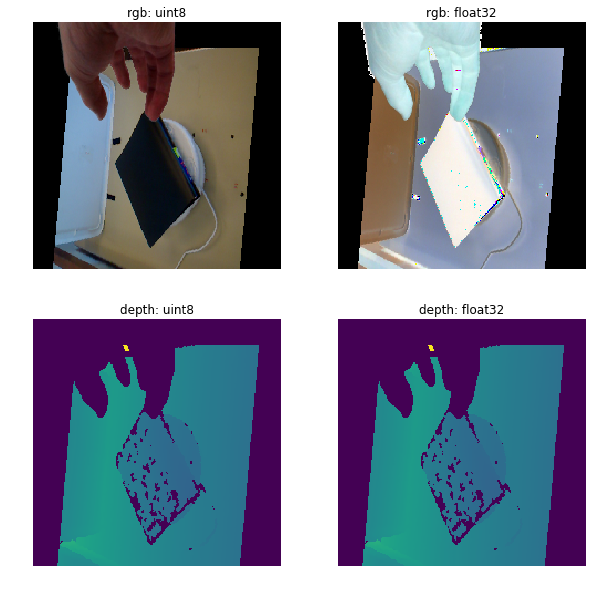

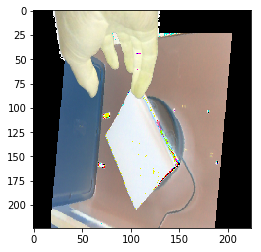

In [8]:
# View an image to make sure it was encoded correctly
# test_tfrecord_path = FLAGS.dataset_dir + 'uw-rgbd-test_train_00000-of-00900.tfrecord'
# test_tfrecord_path = '/local/home/luke/datasets/rgbd-dataset/binder_3_00001-of-00008.tfrecord'
test_tfrecord_path = '/local/home/luke/datasets/rgbd-dataset-tfrecords/binder_3_00001-of-00008.tfrecord'

def _parse_function2(example_proto):
    features = {
        "image/img": tf.FixedLenFeature((), tf.string, default_value=""),
      "image/class/label": tf.FixedLenFeature((), tf.int64, default_value=0)}
    parsed_features = tf.parse_single_example(example_proto, features)
    
    # rgb_img = tf.image.decode_image(parsed_features["image/rgb"], channels=3)
    # depth_img = tf.image.decode_image(parsed_features["image/depth"], channels=0)
    
    img = tf.decode_raw(parsed_features["image/img"], tf.float32)
    
    img = tf.reshape(img, [224,224,4]) 
    # img = tf.reshape(img, [224,112,4])
    
    one_hot = tf.one_hot(parsed_features["image/class/label"],len(class_names), dtype=tf.int32)

    return img, one_hot

filenames_placeholder = tf.placeholder(tf.string, shape=[None])

# dataset = tf.data.TFRecordDataset(filenames_placeholder, buffer_size=int(1e9))
dataset = tf.data.TFRecordDataset(filenames_placeholder)
dataset = dataset.map(_parse_function2, num_parallel_calls=4)
dataset = dataset.repeat()
# dataset = dataset.shuffle(buffer_size=10000) # is this number of batches, or number of examples?
dataset = dataset.batch(2)
# dataset = dataset.apply(tf.contrib.data.map_and_batch(_parse_function, batch_size=32))
dataset = dataset.prefetch(1)

iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

train_tfrecord_filenames = [test_tfrecord_path]

sess = tf.Session('')
sess.run(iterator.initializer, feed_dict={filenames_placeholder: train_tfrecord_filenames})

    
img, label = sess.run(next_element)
# img, label = sess.run(next_element)
# img, label = sess.run(next_element)

print(img.dtype)

plt.figure(figsize=(10,10))

rgb = img[1,...,0:3]
rgb = rgb[:,:,::-1]
print(rgb.shape)
# rgb = np.swapaxes(rgb, 0, 2)

ax1 = plt.subplot(2,2,1)
ax1.imshow(np.asarray(rgb, np.uint8))
ax1.set_axis_off()
ax1.set_title('rgb: uint8')
ax2 = plt.subplot(2,2,2)
ax2.imshow(rgb)
ax2.set_axis_off()
ax2.set_title('rgb: float32')
ax3 = plt.subplot(2,2,3)
ax3.imshow(np.asarray(img[1,...,3], dtype=np.uint16))
ax3.set_axis_off()
ax3.set_title('depth: uint8')
ax4 = plt.subplot(2,2,4)
ax4.imshow(img[1,...,3])
ax4.set_axis_off()
ax4.set_title('depth: float32')

plt.figure()
plt.imshow(np.asarray(np.asarray(img[1,...,0:3],dtype=np.uint8),dtype=np.float32))

print("depth max: " + str(np.max(img[...,-1])))
print("depth min: " + str(np.min(img[...,-1])))
print("rgb max: " + str(np.max(img[...,0:3])))
print("rgb min: " + str(np.min(img[...,0:3])))
    